In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from bsm_math import bsm_value, bsm_vega

Helpful procedures:

In [2]:
def normal_sample(N, k=1, random_state=None):
    np.random.seed(random_state)
    return np.random.normal(0, 1, size=(k, N))

def brownian_motion(T, N, k=1, random_state=None):
    dW = normal_sample(N, k) * sqrt (T / N)
    return np.insert(dW.cumsum(axis=1), 0, 0, 1)

def GBM(T, N, mu, sigma, S_0, k=1, random_state=None):
    time = np.linspace(0, T, N+1)
    W = brownian_motion(T, N, k)
    S = S_0 * np.exp((mu - (sigma ** 2) / 2) * time + sigma * W)
    return (S)

In [3]:
def bsm_value_vector(S, K, T, r, q, sigma, Flag):
    from math import sqrt, exp
    from scipy import stats

    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (np.log(S/K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        value = (S * exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0) -
                 K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    elif Flag == 1:
        value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) -
                 S * exp(-q * T) * stats.norm.cdf(-d1, 0.0, 1.0))
    else:
        value = 'NaN'
    return value

def bsm_delta_vector(S, K, T, r, q, sigma, Flag):
    from math import log, sqrt, exp
    from scipy import stats
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        delta = exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0)
    elif Flag == 1:
        delta = exp(-q * T) * (stats.norm.cdf(d1, 0.0, 1.0) - 1)
    else:
        delta = 'NaN'
    return delta

def bsm_gamma_vector(S, K, T, r, q, sigma):
    from math import log, sqrt, exp
    from scipy import stats
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return (stats.norm.pdf(d1, 0, 1) * exp(-q * T) / (S * sigma * np.sqrt(T)))

def bsm_vega_vector(S, K, T, r, q, sigma):
    from scipy import stats
    S = float(S)
    K = float(K)
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * stats.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def vanilla_dh(paths, K, T, r, q, val_vol, hedging_vol, Flag):
    (n, N) = paths.shape
    maturities = np.linspace(T, 0, n)
    deltas = np.zeros([n, N])
    values = np.zeros([n, N])
    gammas = np.zeros([n, N])
    with np.errstate(divide='ignore',invalid='ignore'):
        for i, m in enumerate(maturities): 
            values[i] = bsm_value_vector(sample[i], K, m, r, q, val_vol, Flag)
            deltas[i] = bsm_delta_vector(sample[i], K, m, r, q, hedging_vol, Flag)
            gammas[i] = bsm_gamma_vector(sample[i], K, m, r, q, hedging_vol)
    trading = np.zeros([n, N])
    trading[0] = deltas[0] * sample[0] - values[0]
    for i in range(1,n):
        trading[i] = sample[i]  * (deltas[i] - deltas[i-1])
    exercise = - K * deltas[-1]
    trading[-1] = trading[-1] + exercise
    values[-1] = 0
    deltas[-1] = 0
    gammas[-1] = 0
    return trading, values, deltas, gammas

def desc_hedging (paths, trading, values, deltas, gammas):
    dh_pl = trading.sum(axis=0)
    cum_pl = trading.cumsum(axis=0) + values - deltas * sample
    daily_pl = np.diff(cum_pl)
    fig = plt.figure(figsize=(10, 6))
    plt.hist(dh_pl)
    plt.title('PL Histogram')
    plt.show()
    print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
          (dh_pl.mean(), dh_pl.std()))
    fig = plt.figure(figsize=(10, 6))
    plt.title('Delta Hedge PL vs Realised vol')
    plt.xlabel('Realised Vol')
    plt.ylabel('Delta Hedge PL')
    plt.scatter(realised_vol, dh_pl)
    plt.show()
    fig = plt.figure(figsize=(10, 6))
    plt.plot(cum_pl.mean(axis=1))
    plt.show()
    return
    

Defining parameters:

In [4]:
T = 1
n_hedges = 260
r = 0
q = 0
vol = 0.3
S_0 = 100
N = 50000
K = 100
implied = 0.3

Simulating Paths:

In [5]:
sample = GBM(T, n_hedges, r-q, vol, S_0, N).T

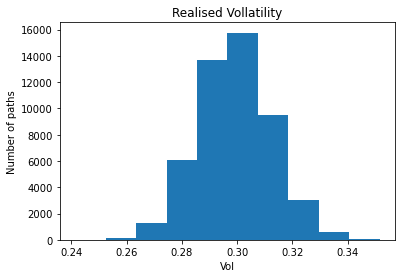

Average realised volatility: 0.2992, Standard deviation of realised volatility: 0.0132


In [6]:
returns = np.log(sample[:-1,]) - np.log(sample[1:,])
realised_vol = (returns).std(axis=0) * sqrt(n_hedges/T)
plt.hist((realised_vol))
plt.title("Realised Vollatility")
plt.ylabel("Number of paths")
plt.xlabel('Vol')
plt.show()
print("Average realised volatility: %.4f, Standard deviation of realised volatility: %.4f" %
      (realised_vol.mean(), realised_vol.std()))

Delta hedging option with its actual vol, fairly priced option:

Delta hedging average PL: 0.0016, Delta hedging PL standard deviation: 0.6492


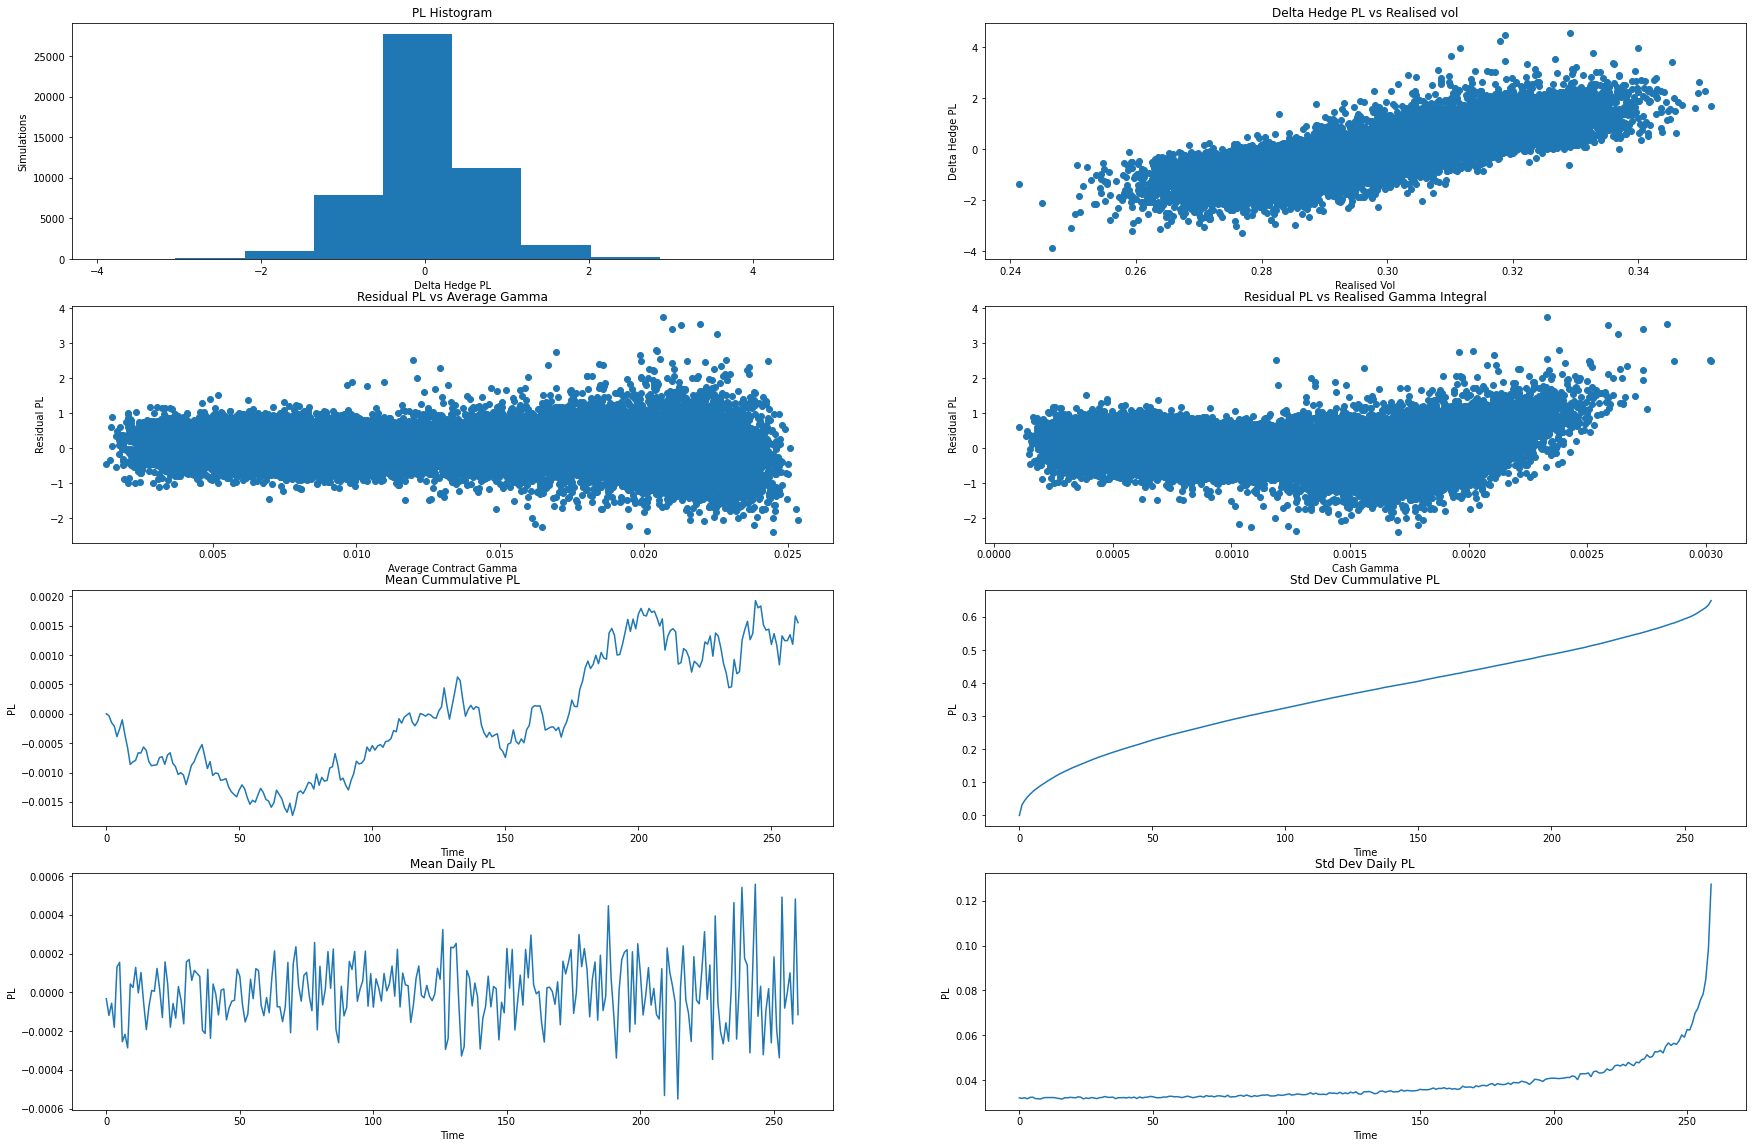

In [7]:
implied = vol
K = S_0
trading, values, deltas, gammas  = vanilla_dh(sample, K, T, r, q, implied, implied, 0)
dh_pl = trading.sum(axis=0)
cum_pl = trading.cumsum(axis=0) + values - deltas * sample
daily_pl = np.diff(cum_pl, axis=0)
avg_gamma = gammas.mean(axis=0)
vega_pl = bsm_value_vector(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, vol, 0)
print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
      (dh_pl.mean(), dh_pl.std()))
figure, axes = plt.subplots(4, 2, figsize=(30,20))
axes[0,0].hist(dh_pl)
axes[0,0].set_title('PL Histogram')
axes[0,0].set_xlabel('Delta Hedge PL')
axes[0,0].set_ylabel('Simulations')
axes[0,1].scatter(realised_vol, dh_pl)
axes[0,1].set_title('Delta Hedge PL vs Realised vol')
axes[0,1].set_xlabel('Realised Vol')
axes[0,1].set_ylabel('Delta Hedge PL')
axes[1,0].scatter(avg_gamma, dh_pl - vega_pl)
axes[1,0].set_title('Residual PL vs Average Gamma')
axes[1,0].set_xlabel('Average Contract Gamma')
axes[1,0].set_ylabel('Residual PL')
axes[1,1].scatter(((returns ** 2) * gammas[:-1]).sum(axis=0), dh_pl - vega_pl)
axes[1,1].set_title('Residual PL vs Realised Gamma Integral')
axes[1,1].set_xlabel('Cash Gamma')
axes[1,1].set_ylabel('Residual PL')
axes[2,0].plot(cum_pl.mean(axis=1))
axes[2,0].set_title('Mean Cummulative PL')
axes[2,0].set_xlabel('Time')
axes[2,0].set_ylabel('PL')
axes[2,1].plot(cum_pl.std(axis=1))
axes[2,1].set_title('Std Dev Cummulative PL')
axes[2,1].set_xlabel('Time')
axes[2,1].set_ylabel('PL')
axes[3,0].plot(daily_pl.mean(axis=1))
axes[3,0].set_title('Mean Daily PL')
axes[3,0].set_xlabel('Time')
axes[3,0].set_ylabel('PL')
axes[3,1].plot(daily_pl.std(axis=1))
axes[3,1].set_title('Std Dev Daily PL')
axes[3,1].set_xlabel('Time')
axes[3,1].set_ylabel('PL')
plt.show()

Delta hedging with implied, unfairly priced option:

Delta hedging average PL: 3.9615, Delta hedging PL standard deviation: 1.9277


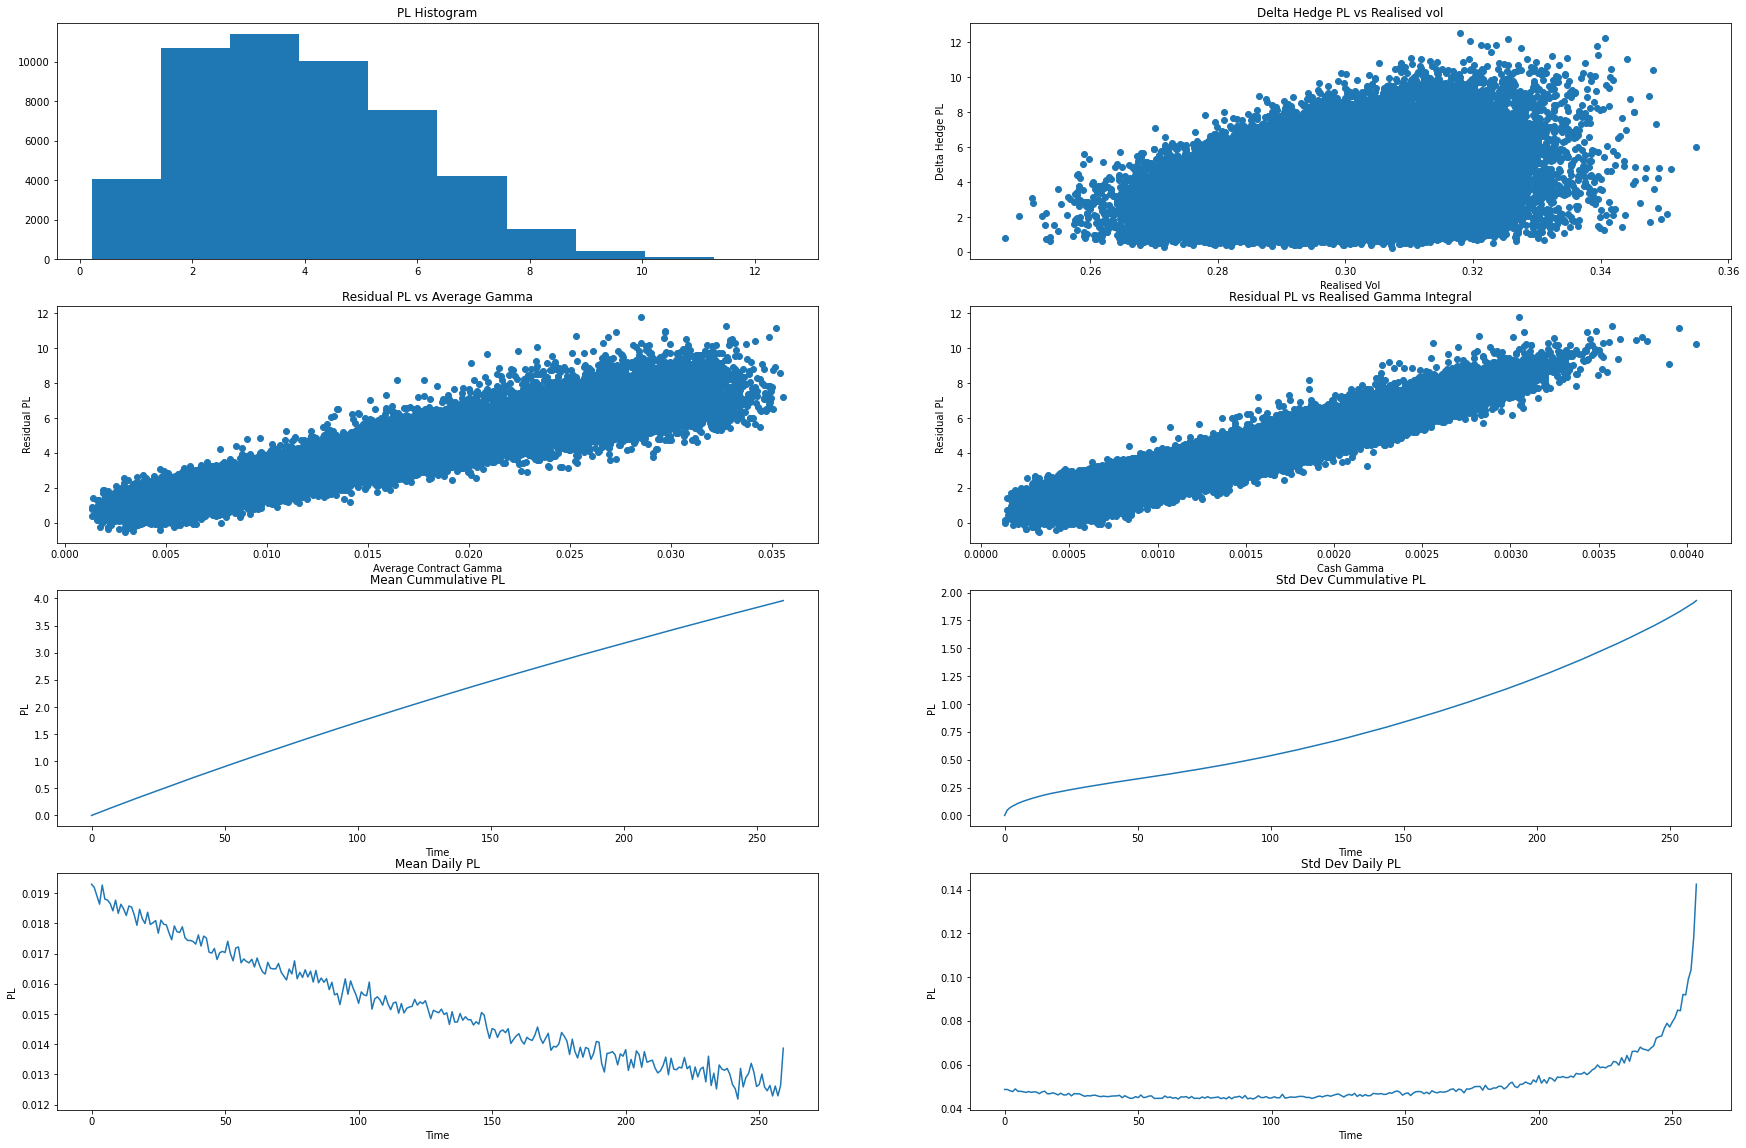

In [8]:
implied = 0.2
K = S_0
trading, values, deltas, gammas  = vanilla_dh(sample, K, T, r, q, implied, implied, 0)
dh_pl = trading.sum(axis=0)
cum_pl = trading.cumsum(axis=0) + values - deltas * sample
daily_pl = np.diff(cum_pl, axis=0)
avg_gamma = gammas.mean(axis=0)
vega_pl = bsm_value_vector(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, vol, 0)
print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
      (dh_pl.mean(), dh_pl.std()))
figure, axes = plt.subplots(4, 2, figsize=(30,20))
axes[0,0].hist(dh_pl)
axes[0,0].set_title('PL Histogram')
axes[0,1].scatter(realised_vol, dh_pl)
axes[0,1].set_title('Delta Hedge PL vs Realised vol')
axes[0,1].set_xlabel('Realised Vol')
axes[0,1].set_ylabel('Delta Hedge PL')
axes[1,0].scatter(avg_gamma, dh_pl - vega_pl)
axes[1,0].set_title('Residual PL vs Average Gamma')
axes[1,0].set_xlabel('Average Contract Gamma')
axes[1,0].set_ylabel('Residual PL')
axes[1,1].scatter(((returns ** 2) * gammas[:-1]).sum(axis=0), dh_pl - vega_pl)
axes[1,1].set_title('Residual PL vs Realised Gamma Integral')
axes[1,1].set_xlabel('Cash Gamma')
axes[1,1].set_ylabel('Residual PL')
axes[2,0].plot(cum_pl.mean(axis=1))
axes[2,0].set_title('Mean Cummulative PL')
axes[2,0].set_xlabel('Time')
axes[2,0].set_ylabel('PL')
axes[2,1].plot(cum_pl.std(axis=1))
axes[2,1].set_title('Std Dev Cummulative PL')
axes[2,1].set_xlabel('Time')
axes[2,1].set_ylabel('PL')
axes[3,0].plot(daily_pl.mean(axis=1))
axes[3,0].set_title('Mean Daily PL')
axes[3,0].set_xlabel('Time')
axes[3,0].set_ylabel('PL')
axes[3,1].plot(daily_pl.std(axis=1))
axes[3,1].set_title('Std Dev Daily PL')
axes[3,1].set_xlabel('Time')
axes[3,1].set_ylabel('PL')
plt.show()

Delta Hedging with true vol, unfairly proced option:

Delta hedging average PL: 3.9541, Delta hedging PL standard deviation: 0.6420


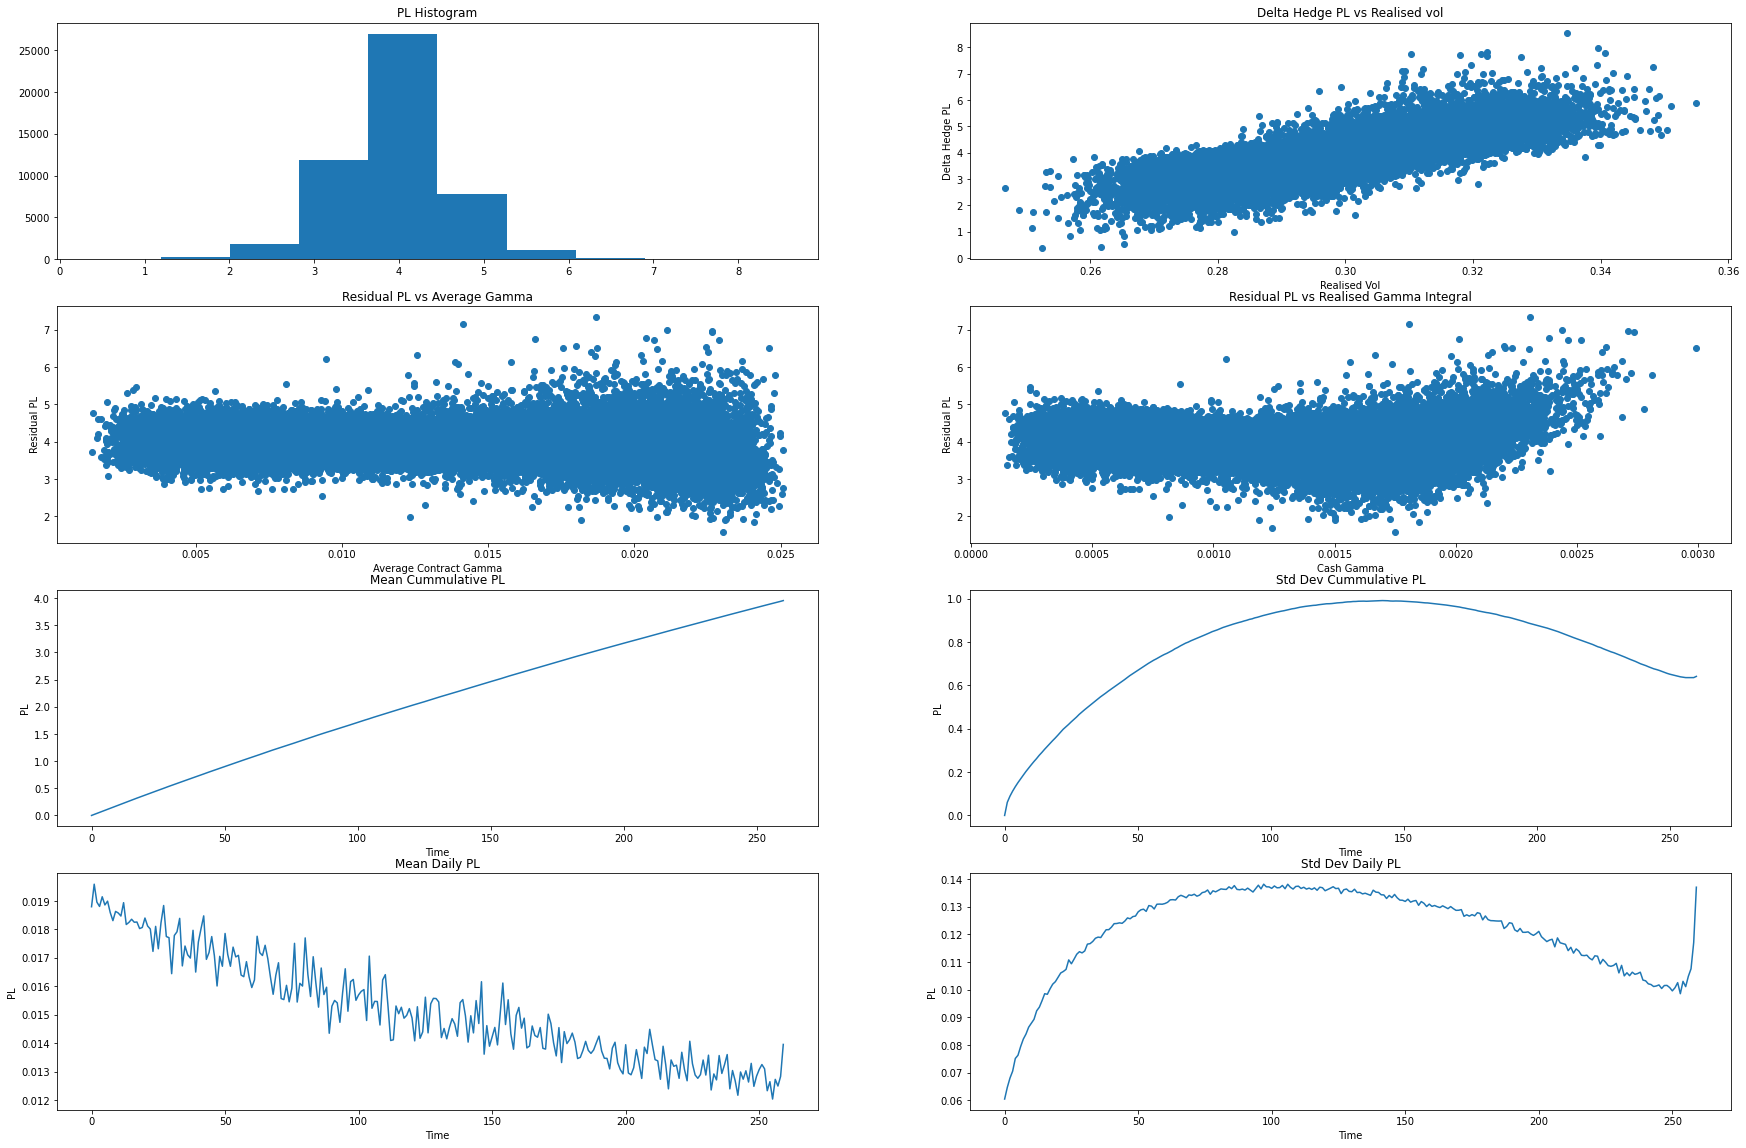

In [9]:
implied = 0.2
K = S_0
trading, values, deltas, gammas  = vanilla_dh(sample, K, T, r, q, implied, vol, 0)
dh_pl = trading.sum(axis=0)
cum_pl = trading.cumsum(axis=0) + values - deltas * sample
daily_pl = np.diff(cum_pl, axis=0)
avg_gamma = gammas.mean(axis=0)
vega_pl = bsm_value_vector(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, vol, 0)
print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
      (dh_pl.mean(), dh_pl.std()))
figure, axes = plt.subplots(4, 2, figsize=(30,20))
axes[0,0].hist(dh_pl)
axes[0,0].set_title('PL Histogram')
axes[0,1].scatter(realised_vol, dh_pl)
axes[0,1].set_title('Delta Hedge PL vs Realised vol')
axes[0,1].set_xlabel('Realised Vol')
axes[0,1].set_ylabel('Delta Hedge PL')
axes[1,0].scatter(avg_gamma, dh_pl - vega_pl)
axes[1,0].set_title('Residual PL vs Average Gamma')
axes[1,0].set_xlabel('Average Contract Gamma')
axes[1,0].set_ylabel('Residual PL')
axes[1,1].scatter(((returns ** 2) * gammas[:-1]).sum(axis=0), dh_pl - vega_pl)
axes[1,1].set_title('Residual PL vs Realised Gamma Integral')
axes[1,1].set_xlabel('Cash Gamma')
axes[1,1].set_ylabel('Residual PL')
axes[2,0].plot(cum_pl.mean(axis=1))
axes[2,0].set_title('Mean Cummulative PL')
axes[2,0].set_xlabel('Time')
axes[2,0].set_ylabel('PL')
axes[2,1].plot(cum_pl.std(axis=1))
axes[2,1].set_title('Std Dev Cummulative PL')
axes[2,1].set_xlabel('Time')
axes[2,1].set_ylabel('PL')
axes[3,0].plot(daily_pl.mean(axis=1))
axes[3,0].set_title('Mean Daily PL')
axes[3,0].set_xlabel('Time')
axes[3,0].set_ylabel('PL')
axes[3,1].plot(daily_pl.std(axis=1))
axes[3,1].set_title('Std Dev Daily PL')
axes[3,1].set_xlabel('Time')
axes[3,1].set_ylabel('PL')
plt.show()

Same for OTM option:

Delta hedging average PL: 0.0031, Delta hedging PL standard deviation: 0.4890


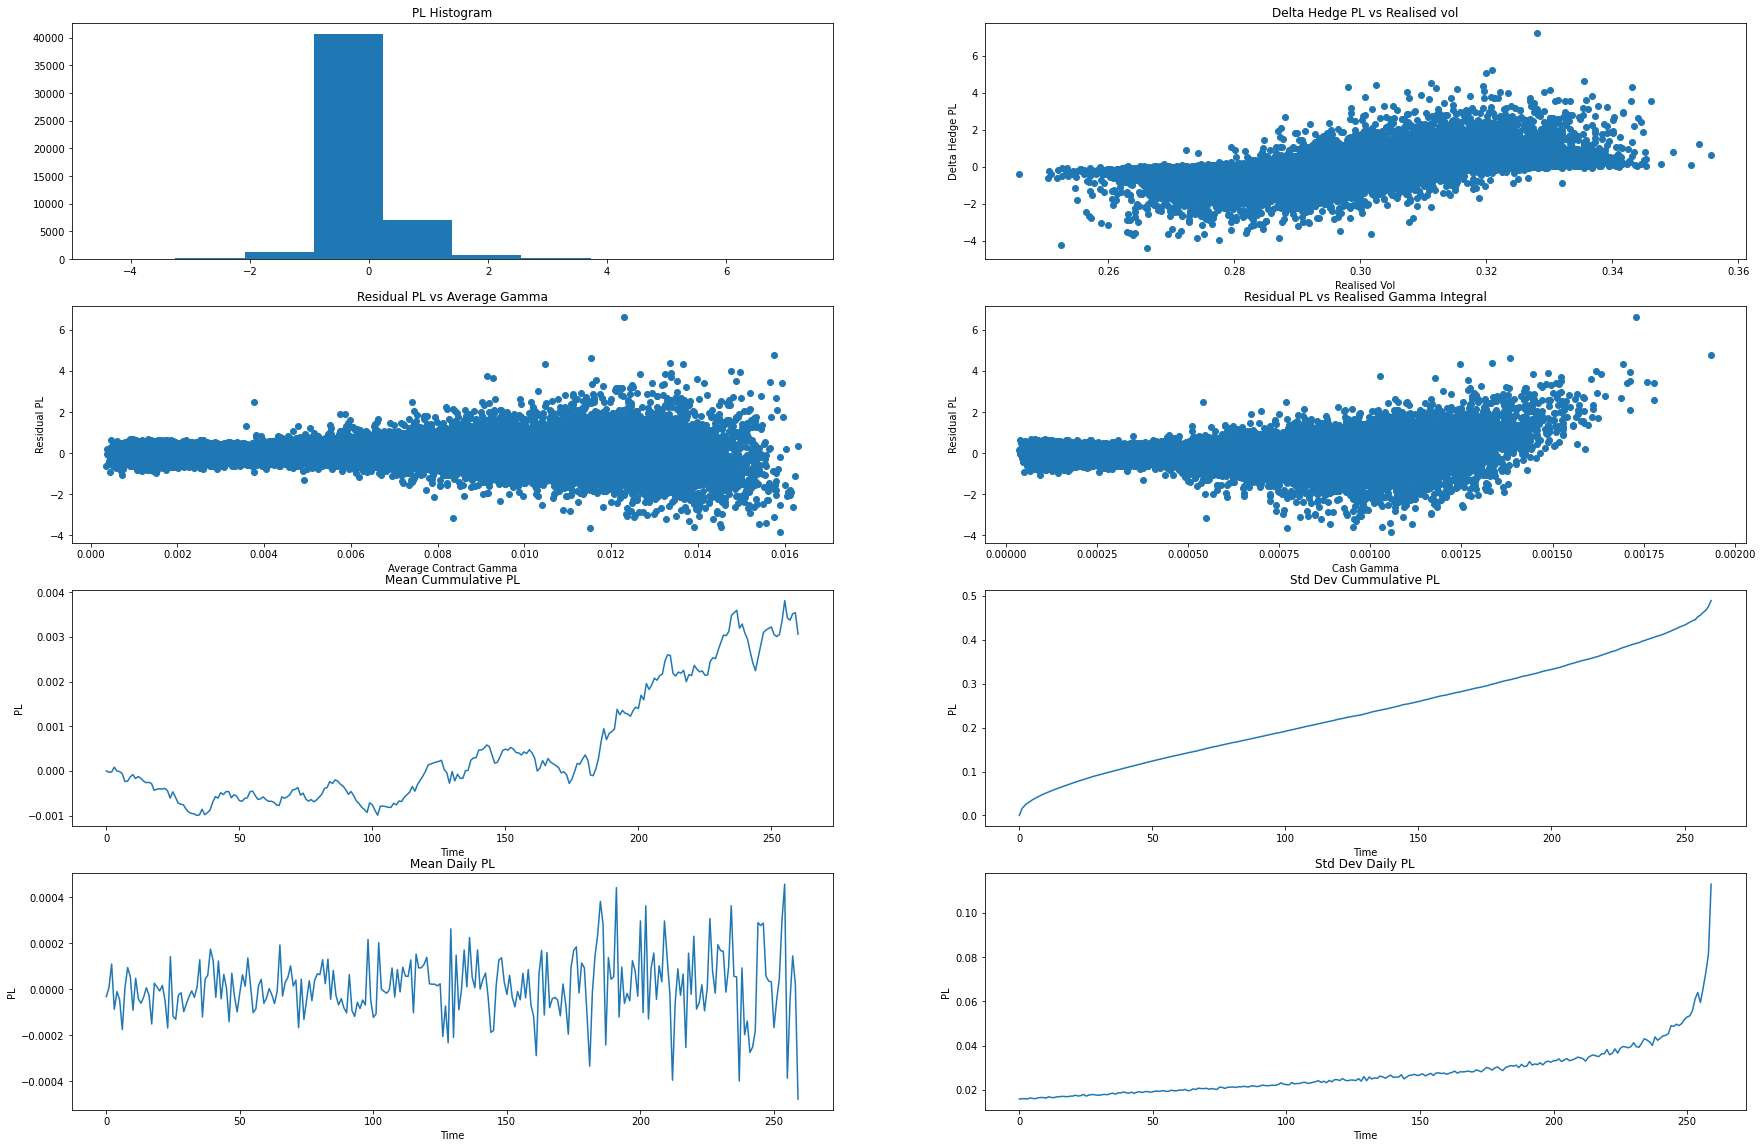

In [108]:
implied = vol
K = 150
trading, values, deltas, gammas  = vanilla_dh(sample, K, T, r, q, implied, implied, 0)
dh_pl = trading.sum(axis=0)
cum_pl = trading.cumsum(axis=0) + values - deltas * sample
daily_pl = np.diff(cum_pl, axis=0)
avg_gamma = gammas.mean(axis=0)
vega_pl = bsm_value_vector(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, vol, 0)
print("Delta hedging average PL: %.4f, Delta hedging PL standard deviation: %.4f" %
      (dh_pl.mean(), dh_pl.std()))
figure, axes = plt.subplots(4, 2, figsize=(30,20))
axes[0,0].hist(dh_pl)
axes[0,0].set_title('PL Histogram')
axes[0,1].scatter(realised_vol, dh_pl)
axes[0,1].set_title('Delta Hedge PL vs Realised vol')
axes[0,1].set_xlabel('Realised Vol')
axes[0,1].set_ylabel('Delta Hedge PL')
axes[1,0].scatter(avg_gamma, dh_pl - vega_pl)
axes[1,0].set_title('Residual PL vs Average Gamma')
axes[1,0].set_xlabel('Average Contract Gamma')
axes[1,0].set_ylabel('Residual PL')
axes[1,1].scatter(((returns ** 2) * gammas[:-1]).sum(axis=0), dh_pl - vega_pl)
axes[1,1].set_title('Residual PL vs Realised Gamma Integral')
axes[1,1].set_xlabel('Cash Gamma')
axes[1,1].set_ylabel('Residual PL')
axes[2,0].plot(cum_pl.mean(axis=1))
axes[2,0].set_title('Mean Cummulative PL')
axes[2,0].set_xlabel('Time')
axes[2,0].set_ylabel('PL')
axes[2,1].plot(cum_pl.std(axis=1))
axes[2,1].set_title('Std Dev Cummulative PL')
axes[2,1].set_xlabel('Time')
axes[2,1].set_ylabel('PL')
axes[3,0].plot(daily_pl.mean(axis=1))
axes[3,0].set_title('Mean Daily PL')
axes[3,0].set_xlabel('Time')
axes[3,0].set_ylabel('PL')
axes[3,1].plot(daily_pl.std(axis=1))
axes[3,1].set_title('Std Dev Daily PL')
axes[3,1].set_xlabel('Time')
axes[3,1].set_ylabel('PL')
plt.show()

Heavy bit follows, simply shows simulations consistant with Black-Scholes, std dev -> 0 as number of periods rises:

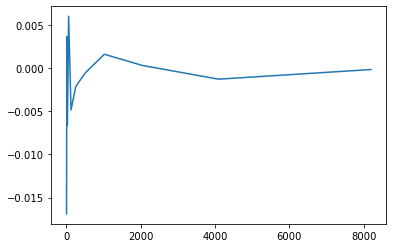

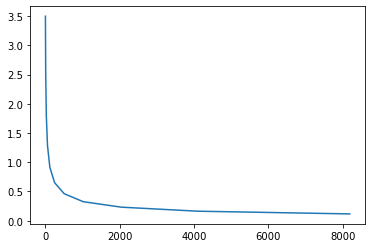

In [9]:
dh_stdev = []
dh_mean = []
freq = 2 ** np.linspace(3, 13, 11)
for i in freq:
    sample = GBM(T, int(i), r-q, vol, K, N).T
    trading = (vanilla_dh(sample, K, T, r, q, implied, implied, 0)[0])
    dh_stdev.append(trading.sum(axis=0).std())
    dh_mean.append(trading.sum(axis=0).mean())
plt.plot(freq, dh_mean)
plt.show()
plt.plot(freq, dh_stdev)
plt.show()